In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import V1_dr_eps, V1_all_dr_eps

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/FigSabc/"

In [19]:
lb_h = np.array([0., 0., 0., 0.])
ub_h = np.array([10., 20., 5., 5.])

lb_dh = np.array([0., 0.])
ub_dh = np.array([10., 30.])

h = Parameter("h", 4, lb=lb_h, ub=ub_h)
dh = Parameter("dh", 2, lb=lb_dh, ub=ub_dh)
parameters = [h, dh]

sigma_eps = 0.0

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [20]:
# Define model
name = "V1Circuit"
model = Model(name, parameters)

In [21]:
from epi.example_eps import euler_sim, euler_sim_traj, load_W
import tensorflow as tf

X_INIT = tf.constant(np.random.normal(1.0, 0.01, (1, 4, 1)).astype(np.float32))

def V1_sim(h, dh):
    h = h[:, :, None]
    dh = tf.concat((dh, tf.zeros_like(dh, dtype=tf.float32)), axis=1)[:, :, None]
   
    n = 2.
    dt = 0.005
    T = 100
    tau = 0.02

    _x_shape = tf.ones_like(h, dtype=tf.float32)
    x_init = _x_shape*X_INIT

    W = 1.*load_W()

    def f(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau

    r_t = euler_sim_traj(f, x_init, dt, T)
    return r_t

# Define eps
diff_prod_mean = -.5
diff_sum_mean = 0.
def SV_flip(h, dh):
    h = h[:, :, None]
    dh = tf.concat((dh, tf.zeros_like(dh, dtype=tf.float32)), axis=1)[:, :, None]
   
    n = 2.
    dt = 0.005
    T = 100
    tau = 0.02

    _x_shape = tf.ones_like(h, dtype=tf.float32)
    x_init = _x_shape*X_INIT

    W = 1.*load_W()

    def f1(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + noise) ** n)) / tau

    def f2(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau

    ss1 = euler_sim(f1, x_init, dt, T)
    ss2 = euler_sim(f2, x_init, dt, T)
    
    diff1 = ss1[:,2]-ss1[:,3]
    diff2 = ss2[:,2]-ss2[:,3]
    diff_prod = diff1*diff2
    diff_sum = diff1+diff2
    T_x = tf.stack((diff_prod, 
                    diff_sum, 
                    (diff_prod - diff_prod_mean) ** 2, 
                    (diff_sum-diff_sum_mean) ** 2), axis=1)

    return T_x



model.set_eps(SV_flip)

In [22]:
D = sum([param.D for param in model.parameters])
lb = np.concatenate([param.lb for param in model.parameters])
ub = np.concatenate([param.ub for param in model.parameters])
print(D, lb)

6 [0. 0. 0. 0. 0. 0.]


In [23]:
M = 1000
num_keep = 25

mean = [diff_prod_mean, 0.]
std = [0.125, 0.125]

def accept_inds(T_x, mean ,std):
    return np.logical_and(np.logical_and(mean[0]-2*std[0] < T_x[:,0], T_x[:,0] < mean[0]+2*std[0]),
                          np.logical_and(mean[1]-2*std[1] < T_x[:,1], T_x[:,1] < mean[1]+2*std[1]))

num_found = 0
z = None
T_x = None
x = []
while (num_found < num_keep):
    _z = np.zeros((M, D))
    for j in range(D):
        _z[:,j] = np.random.uniform(lb[j], ub[j], (M,))
    _T_x = model.eps(_z).numpy()

    inds = accept_inds(_T_x, mean, std)
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    print('%d/%d\r' % (num_found, num_keep), end='')
    x.append(num_found)

num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]



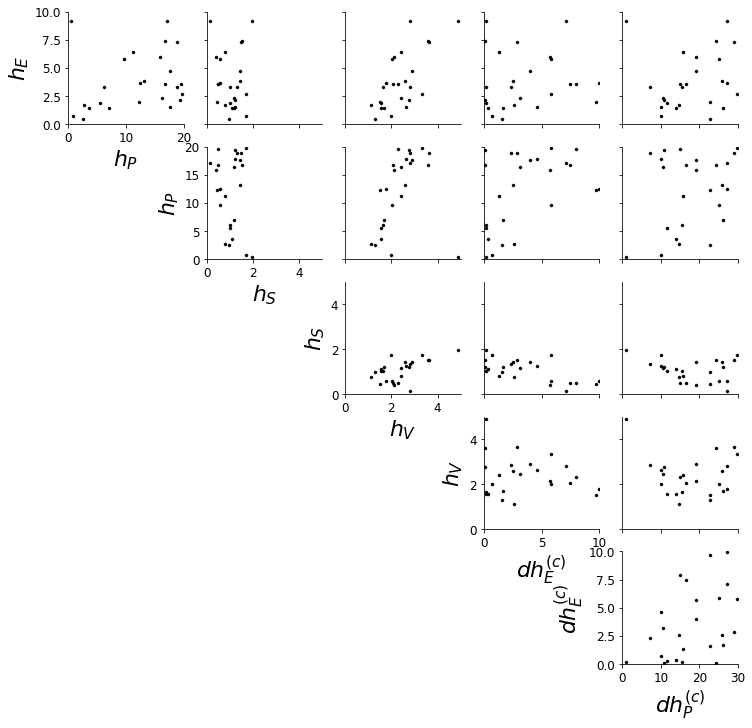

In [24]:
num_plot = 500
fontsize = 14
z_labels = [r'$h_E$', r'$h_P$', r'$h_S$', r'$h_V$', r'$dh^{(c)}_E$', r'$dh^{(c)}_P$']
fig = pairplot(z[:num_plot], np.arange(6), z_labels,
               fontsize=22,
               lb=lb, ub=ub,
               c = None)
plt.savefig(figdir + 'SV_flip_ABC_z.png')
               #c_label='prod')

In [25]:
T_x_sim = model.eps(z).numpy()

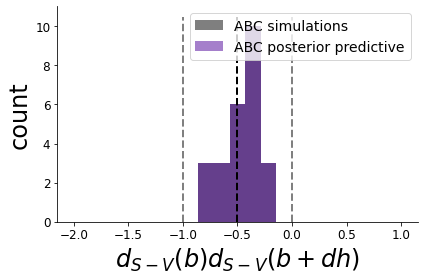

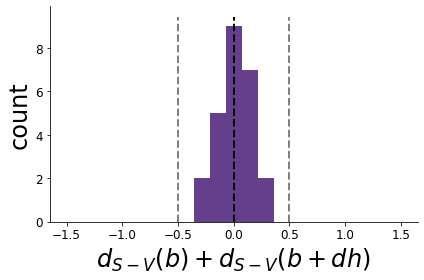

In [26]:
from epi.util import plot_T_x 

nbins=21
xmins = [-2, -1.5]
xmaxs = [1, 1.5]
xlabels = [r"$d_{S-V}(b)d_{S-V}(b+dh)$",
           r"$d_{S-V}(b) + d_{S-V}(b+dh)$"]

if diff_prod_mean == -0.25:
    mu = np.array([-0.25, 0.0, 0.125**2, 0.125**2])
else:
    mu = np.array([-0.5, 0.0, 0.25**2, 0.25**2])

for i in range(2):
    ax = plot_T_x(T_x[:,i], T_x_sim[:,i], bins=nbins, 
                 x_mean=mu[i], x_std=np.sqrt(mu[i+2]),
                 xmin=xmins[i], xmax=xmaxs[i], 
                 xlabel=xlabels[i], ylim=None, fontsize=24)
    if i==0:
        plt.legend()
    plt.tight_layout()
    plt.savefig(figdir + 'SVflip_ABC_Tx%d.png' % (i+1))

In [30]:
def plot_sims(z, sigma_eps=0.05, gamma_lims=(-1,2), M=200, subscript=None, fontsize=14, ylims=None):
    h = z[:4][None,:]
    dh = z[4:][None,:]

    _h = np.tile(h, [M, 1])
    _dh = np.tile(dh, [M, 1])
    _dh = np.ones((M,2))
    r_ts = []
    gammas = np.concatenate((np.array([0,1,]), np.linspace(gamma_lims[0], gamma_lims[1], 101)))
    for gamma in gammas:
        r_ts.append(V1_sim(_h, gamma*_dh))
    r_ts = np.array(r_ts)
    mean_r_ts = np.mean(r_ts, axis=1)
    std_r_ts = np.std(r_ts, axis=1)
    
    _mean_r = np.mean(r_ts[:,:,:,50:], axis=3)
    _std_r = np.std(r_ts[:,:,:,50:], axis=3)
    mean_r = np.mean(_mean_r, axis=1)
    std_r = np.mean(_std_r, axis=1)

    t = 0.005*np.arange(101)
    fig, axs = plt.subplots(1,3, figsize=(12,4))

    for i in range(4):
        axs[0].plot(t, mean_r_ts[0,i,:], c=colors[i])
        axs[0].fill_between(t, 
                            mean_r_ts[0,i,:]-std_r_ts[0,i,:],
                            mean_r_ts[0,i,:]+std_r_ts[0,i,:],
                            facecolor=colors[i], alpha=0.5)

        axs[1].plot(t, mean_r_ts[-1,i,:], c=colors[i])
        axs[1].fill_between(t, 
                            mean_r_ts[-1,i,:]-std_r_ts[-1,i,:],
                            mean_r_ts[-1,i,:]+std_r_ts[-1,i,:],
                            facecolor=colors[i], alpha=0.5)

        axs[2].plot(gammas[2:], mean_r[2:,i], c=colors[i])
        axs[2].fill_between(gammas[2:], 
                            mean_r[2:,i]-std_r[2:,i],
                            mean_r[2:,i]+std_r[2:,i],
                            facecolor=colors[i], alpha=0.5)
        
    axs[0].set_xlabel(r'$t$ (s)', fontsize=fontsize)
    axs[0].set_ylabel(r'$r(t)$', fontsize=fontsize)
    if subscript is not None:
        axs[0].set_title(r'$b_%d$' % subscript, fontsize=fontsize+4)
    else:
        axs[0].set_title(r'$b$', fontsize=fontsize+4)
    
    axs[1].set_xlabel(r'$t$ (s)', fontsize=fontsize)
    axs[1].set_ylabel(r'$r(t)$', fontsize=fontsize)
    if subscript is not None:
        axs[1].set_title(r'$b_%d + dh^{(c)}_%d$' % (subscript, subscript), fontsize=fontsize+4)
    else:
        axs[1].set_title(r'$b + dh^{(c)}$', fontsize=fontsize+4)
    
    axs[2].set_xlabel(r"$c \propto $contrast", fontsize=fontsize)
    axs[2].set_ylabel(r'$r_{ss}$', fontsize=fontsize)
    if subscript is not None:
        axs[2].set_title(r'$b_%d + c dh^{(c)}_%d$' % (subscript, subscript), fontsize=fontsize+4)
    else:
        axs[2].set_title(r'$b + dh^{(c)}$', fontsize=fontsize+4)
        
    if ylims is not None:
        for i in range(3):
            axs[i].set_ylim(ylims)

    return gammas[2:], mean_r_ts[2:], std_r_ts[2:]

In [31]:
def ISN_coeff(h):
    h_E = h[:,0]
    h = h[:, :, None]
    W = 1.*load_W()

    n = 2.
    dt = 0.005
    T = 100
    tau = 0.02

    _x_shape = tf.ones((h.shape[0], 4, 1), dtype=tf.float32)
    x_init = _x_shape*X_INIT
    
    sigma_eps = 0.
    def f(y):
        #omega = tf.random.normal(h.shape, 0., 1.)
        #noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h) ** n)) / tau
    

    r_ss = euler_sim(f, x_init, dt, T)
    u_E = tf.tensordot(W[:,0,:], r_ss, [1,1])
    u_E = u_E[0,:] + h_E
    u_E = tf.nn.relu(u_E)
    isn_coeff = 1.-2.*(u_E)*W[:,0,0]
    
    return isn_coeff[:,None]

isn1 = ISN_coeff(z[:,:4]).numpy()
z2 = z[:,:4].copy()
z2[:,:2] + z[:,4:6]
isn2 = ISN_coeff(z2).numpy()
print(isn1[:5])
print(isn2[:5])

[[0.9842817 ]
 [0.9153318 ]
 [0.6268861 ]
 [0.97018415]
 [0.72477317]]
[[0.9842817 ]
 [0.9153318 ]
 [0.6268861 ]
 [0.97018415]
 [0.72477317]]


[ 3.28341091 18.85911104  1.31666911  2.82403912  2.34833464  7.14787776]
[0.9842817] [0.9842817]


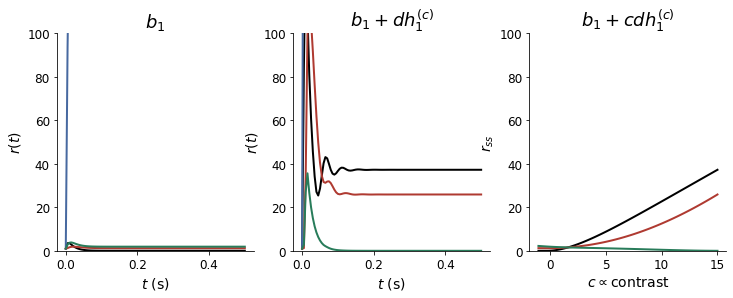

[ 3.5351128  16.69542518  0.48233377  2.05498556  7.46763552 16.64843318]
[0.9153318] [0.9153318]


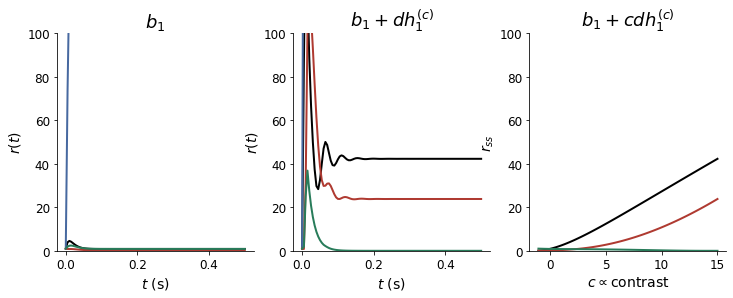

[ 6.42323424 11.16462898  0.78147963  2.4163421   1.2952536  15.85373689]
[0.6268861] [0.6268861]


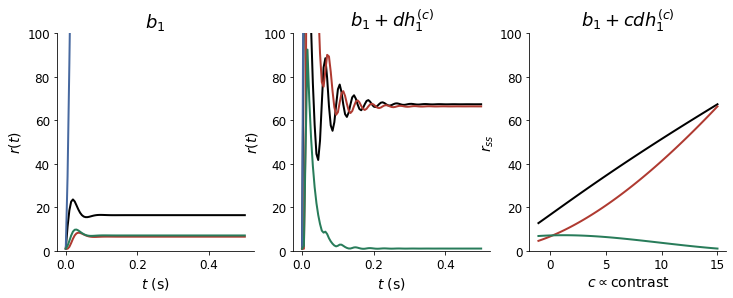

[ 0.41756236  2.49400363  0.96708072  1.28762284  1.56282156 22.793216  ]
[0.97018415] [0.97018415]


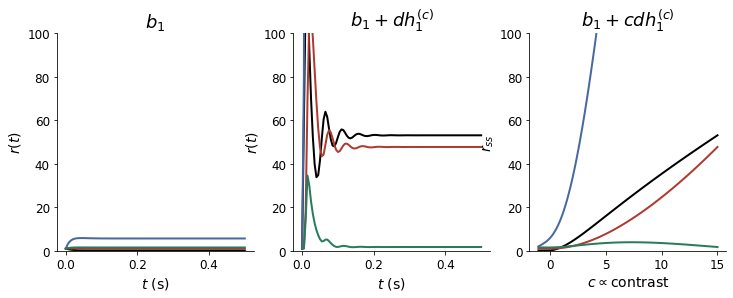

[ 6.00728992 15.86467726  0.39425047  2.11159364  5.72639682 19.26526776]
[0.72477317] [0.72477317]


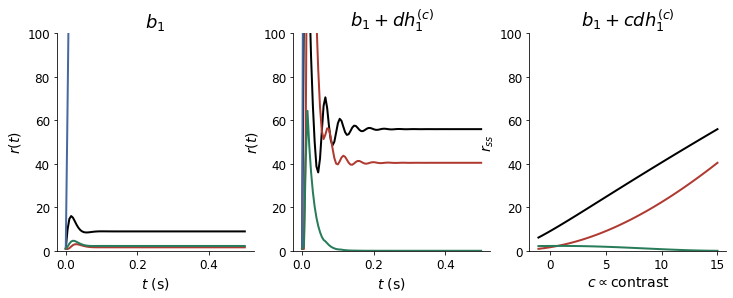

[ 5.75577586  9.69716947  0.5891597   2.0065584   5.84562835 25.19780636]
[0.64380854] [0.64380854]


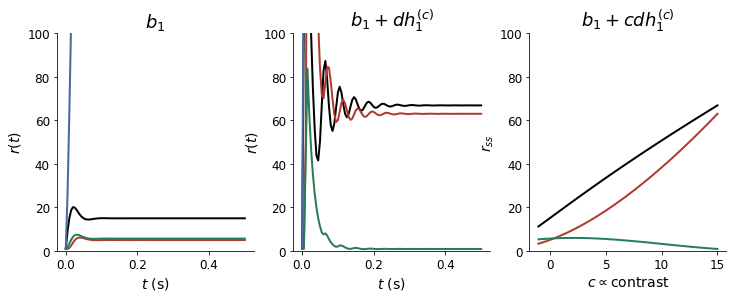

[ 3.69852987 12.4830418   0.5672685   1.77443187  9.94560073 27.13889475]
[0.82467747] [0.82467747]


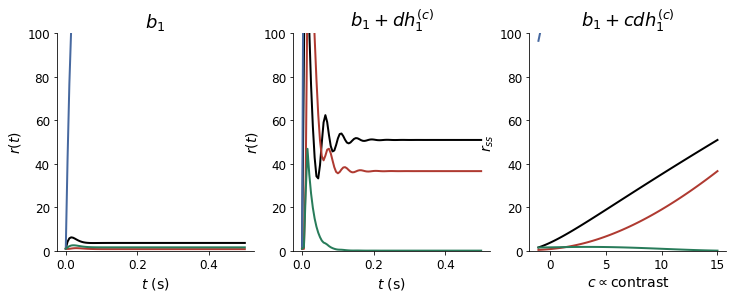

[ 7.36491575 16.80529882  1.51136073  3.60100925  0.07119178 24.42626492]
[0.66110945] [0.66110945]


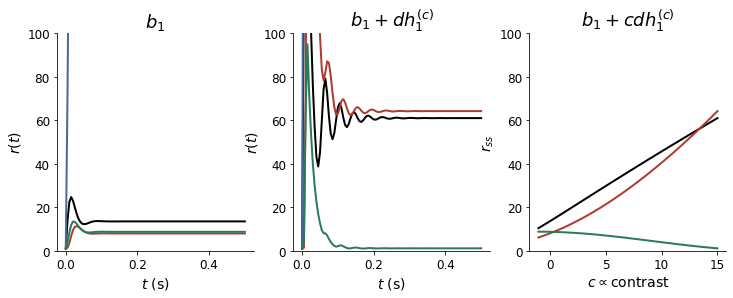

[ 1.97463415 12.23998118  0.42864699  1.50357916  9.68716458 22.88760998]
[0.96033806] [0.96033806]


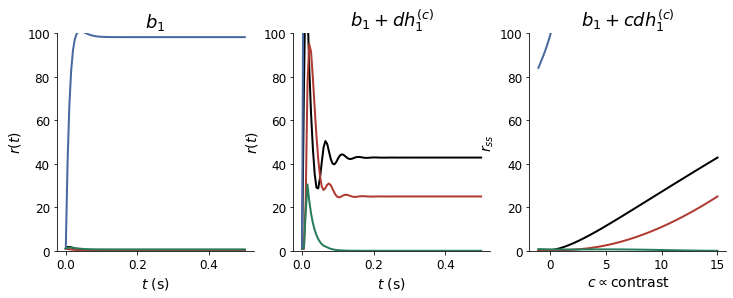

[ 3.59477027 19.55362153  0.48806381  2.29977533  7.95168565 15.05854013]
[0.97267246] [0.97267246]


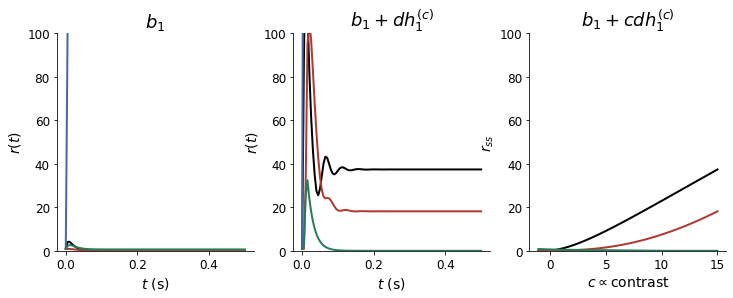

[ 1.50537302 17.72623175  1.2357393   2.63888176  4.6132157  10.01117243]
[1.] [1.]


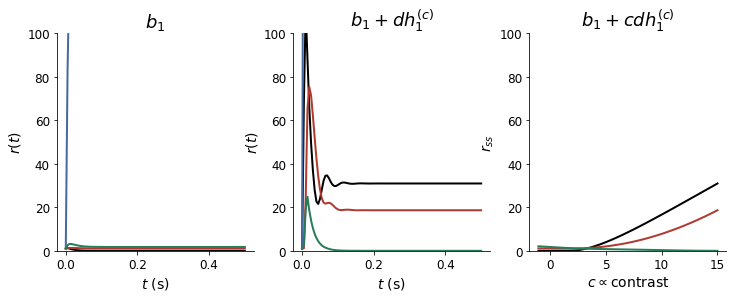

[ 1.44133207  3.60606347  1.09392266  1.551994    0.39004004 14.03998317]
[0.88438666] [0.88438666]


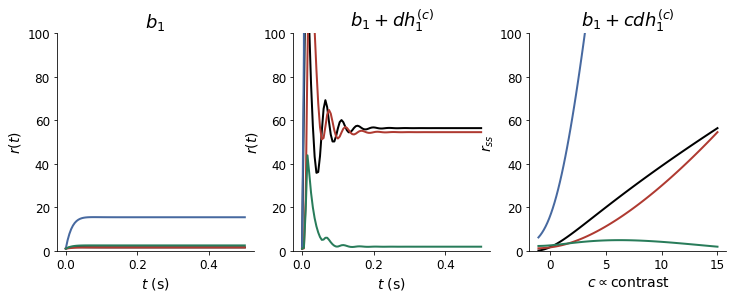

[ 2.11519126 19.31551072  1.21679267  2.75614286  0.11697249 10.94746223]
[1.] [1.]


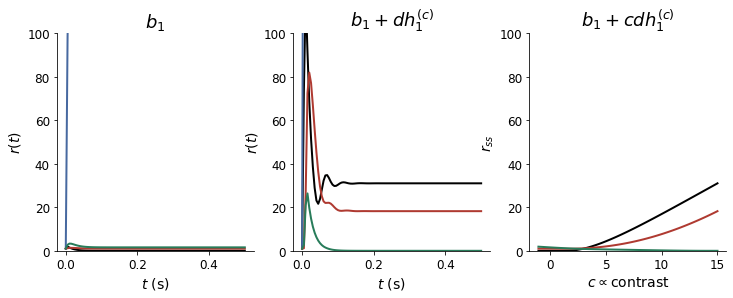

[9.16303906 0.40413694 1.9548232  4.8898389  0.20027935 0.96831159]
[0.35740924] [0.35740924]


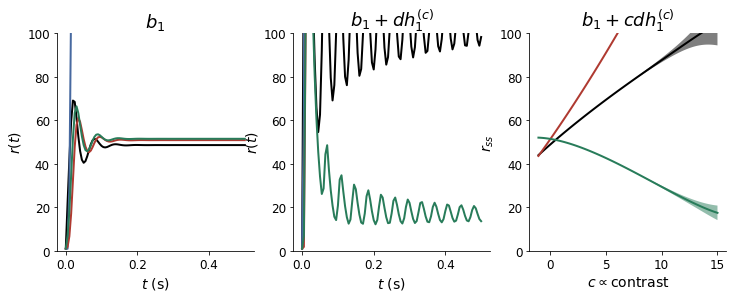

[ 1.8615676   5.58657064  1.00732046  1.54840319  0.22768882 11.69953525]
[0.8685347] [0.8685347]


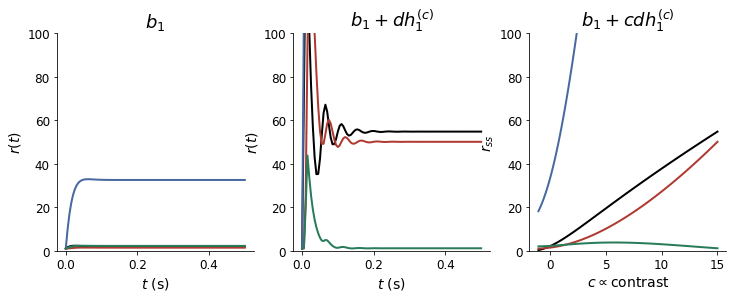

[ 1.42298518  6.99979851  1.18375412  1.66672489  1.68429282 26.23130705]
[0.9250944] [0.9250944]


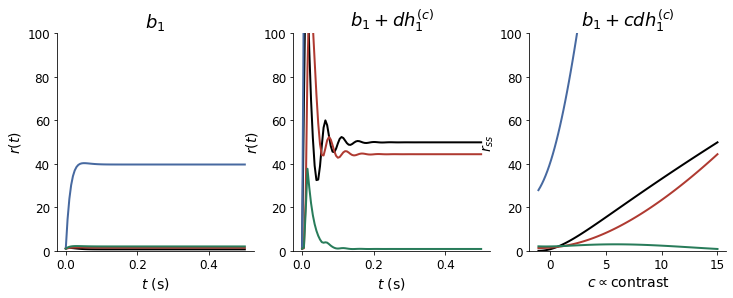

[ 0.73578081  0.76253181  1.72254838  1.99462005  0.70809243 10.14708597]
[0.9339176] [0.9339176]


KeyboardInterrupt: 

In [34]:
for i in range(num_keep):
    print(z[i,:6])
    print(isn1[i], isn2[i])
    _, _, _ = plot_sims(z[i,:6], 0., subscript=1, gamma_lims=(-1, 15.), ylims=[0,100], M=20)
    plt.show()
    

In [ ]:
plt.hist(isn1)